This is an exploration of the whole series of mortality data from the CDC.

First let's configure logging, including turning off the preconfigured loggers.

In [1]:
from logging import Formatter
from logging import getLogger
from logging import INFO
from logging import StreamHandler

logger = getLogger(__name__)
logger.handlers.clear()
handler = StreamHandler()
handler.setLevel(INFO)
handler.setFormatter(Formatter('%(name)s - %(asctime)s - %(levelname)s - %(message)s'))
logger.addHandler(handler)

Let's list all the files. We note that we have data files in CSV format representing the years 2005-2015, inclusive (11 years).

In [2]:
from os import walk
from os.path import join

for dirname, _, filenames in walk('../input/mortality/'):
    for filename in filenames:
        logger.info(msg=join(dirname, filename))

__main__ - 2023-06-15 16:45:17,151 - INFO - ../input/mortality/2014_codes.json
__main__ - 2023-06-15 16:45:17,152 - INFO - ../input/mortality/2007_data.csv
__main__ - 2023-06-15 16:45:17,153 - INFO - ../input/mortality/2007_codes.json
__main__ - 2023-06-15 16:45:17,154 - INFO - ../input/mortality/2012_data.csv
__main__ - 2023-06-15 16:45:17,155 - INFO - ../input/mortality/2010_data.csv
__main__ - 2023-06-15 16:45:17,156 - INFO - ../input/mortality/2009_data.csv
__main__ - 2023-06-15 16:45:17,157 - INFO - ../input/mortality/2011_data.csv
__main__ - 2023-06-15 16:45:17,158 - INFO - ../input/mortality/2015_codes.json
__main__ - 2023-06-15 16:45:17,161 - INFO - ../input/mortality/2011_codes.json
__main__ - 2023-06-15 16:45:17,162 - INFO - ../input/mortality/2006_data.csv
__main__ - 2023-06-15 16:45:17,163 - INFO - ../input/mortality/2010_codes.json
__main__ - 2023-06-15 16:45:17,164 - INFO - ../input/mortality/2005_data.csv
__main__ - 2023-06-15 16:45:17,165 - INFO - ../input/mortality/200

If we try to load up all of the data we may run out of memory, so let's start by doing one big load of just the columns we initially want across all 11 years; we'll use a list comprehension and concat() to avoid saving two copies of the data, and we'll hide the progress information in our CSV reading code.

In [3]:
from pandas import concat
from pandas import read_csv
from pandas import DataFrame

USECOLS = ['activity_code', 'autopsy', 'current_data_year', 'day_of_week_of_death', 'detail_age', 'education_reporting_flag',
           'injury_at_work', 'manner_of_death', 'marital_status', 'method_of_disposition', 'month_of_death', 
           'place_of_death_and_decedents_status', 'race', 'resident_status', 'sex']

def read(filename: str) -> DataFrame:
    logger = getLogger(name=__name__)
    logger.info(msg='reading {}'.format(filename))
    result_df = read_csv(filepath_or_buffer=filename, low_memory=False, usecols=USECOLS)
    logger.info(msg='read {} rows.'.format(len(result_df)))
    logger.debug(msg=result_df.columns)
    return result_df

df = concat( [read(filename='../input/mortality/{}_data.csv'.format(year)) for year in range(2005, 2015)])

__main__ - 2023-06-15 16:45:17,224 - INFO - reading ../input/mortality/2005_data.csv
__main__ - 2023-06-15 16:45:34,224 - INFO - read 2452506 rows.
__main__ - 2023-06-15 16:45:34,225 - INFO - reading ../input/mortality/2006_data.csv
__main__ - 2023-06-15 16:45:50,119 - INFO - read 2430725 rows.
__main__ - 2023-06-15 16:45:50,121 - INFO - reading ../input/mortality/2007_data.csv
__main__ - 2023-06-15 16:46:05,886 - INFO - read 2428343 rows.
__main__ - 2023-06-15 16:46:05,888 - INFO - reading ../input/mortality/2008_data.csv
__main__ - 2023-06-15 16:46:22,128 - INFO - read 2476811 rows.
__main__ - 2023-06-15 16:46:22,129 - INFO - reading ../input/mortality/2009_data.csv
__main__ - 2023-06-15 16:46:38,802 - INFO - read 2441219 rows.
__main__ - 2023-06-15 16:46:38,804 - INFO - reading ../input/mortality/2010_data.csv
__main__ - 2023-06-15 16:46:55,340 - INFO - read 2472542 rows.
__main__ - 2023-06-15 16:46:55,341 - INFO - reading ../input/mortality/2011_data.csv
__main__ - 2023-06-15 16:47

Let's see how much data we have.

In [4]:
logger.info(msg='row count: {}'.format(len(df)))

__main__ - 2023-06-15 16:48:08,392 - INFO - row count: 25002475


Let's make our first graph: a plot of the total deaths for each year.
And let's use lmplot() to include a trend line.

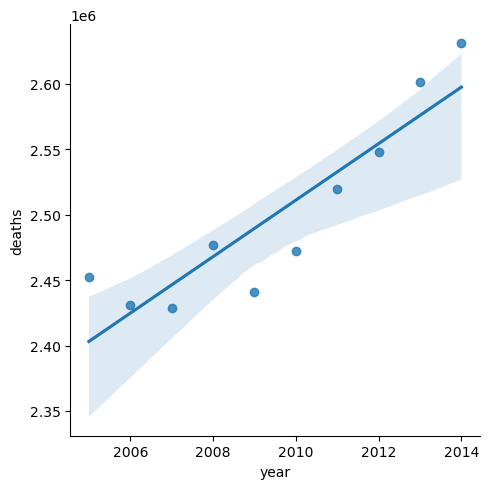

In [5]:
from seaborn import lmplot
%matplotlib inline
annual_total_df = df['current_data_year'].value_counts().to_frame(name='deaths').reset_index()
annual_total_df.columns = ['year', 'deaths']
lmplot(data=annual_total_df, x='year', y='deaths',)

Let's try splitting out male and female deaths.

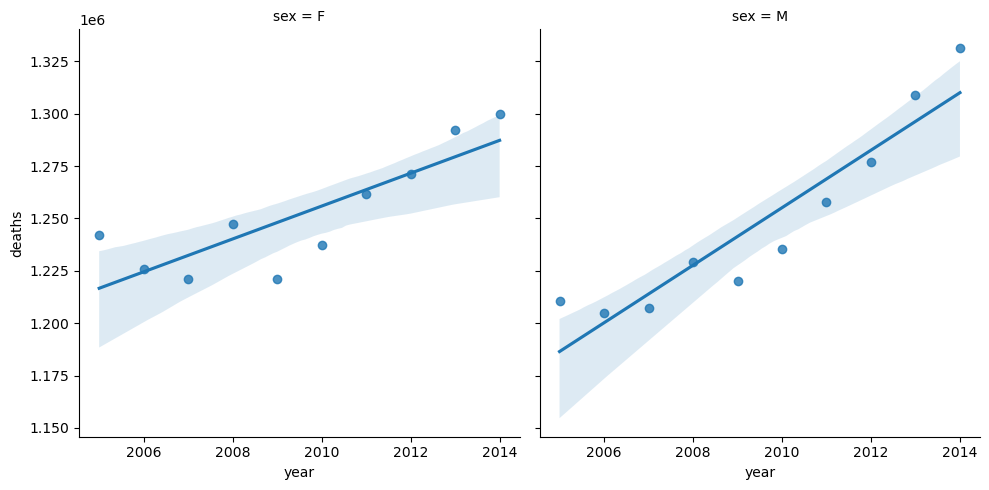

In [6]:
lmplot(col='sex', 
       data=df.groupby(by=['current_data_year', 'sex']).size().reset_index().rename(columns={'current_data_year': 'year', 0: 'deaths'}),
       x='year', y='deaths',)

Let's get the race names, add a column for the race name, and split out the deaths by race.

In [7]:
from json import load
with open(file='../input/mortality/2015_codes.json', mode='r', encoding='utf-8', ) as codes_fp:
    codes = load(fp=codes_fp,)
df['race_name'] = df['race'].replace(to_replace={int(key): value for key, value in codes['race'].items()})

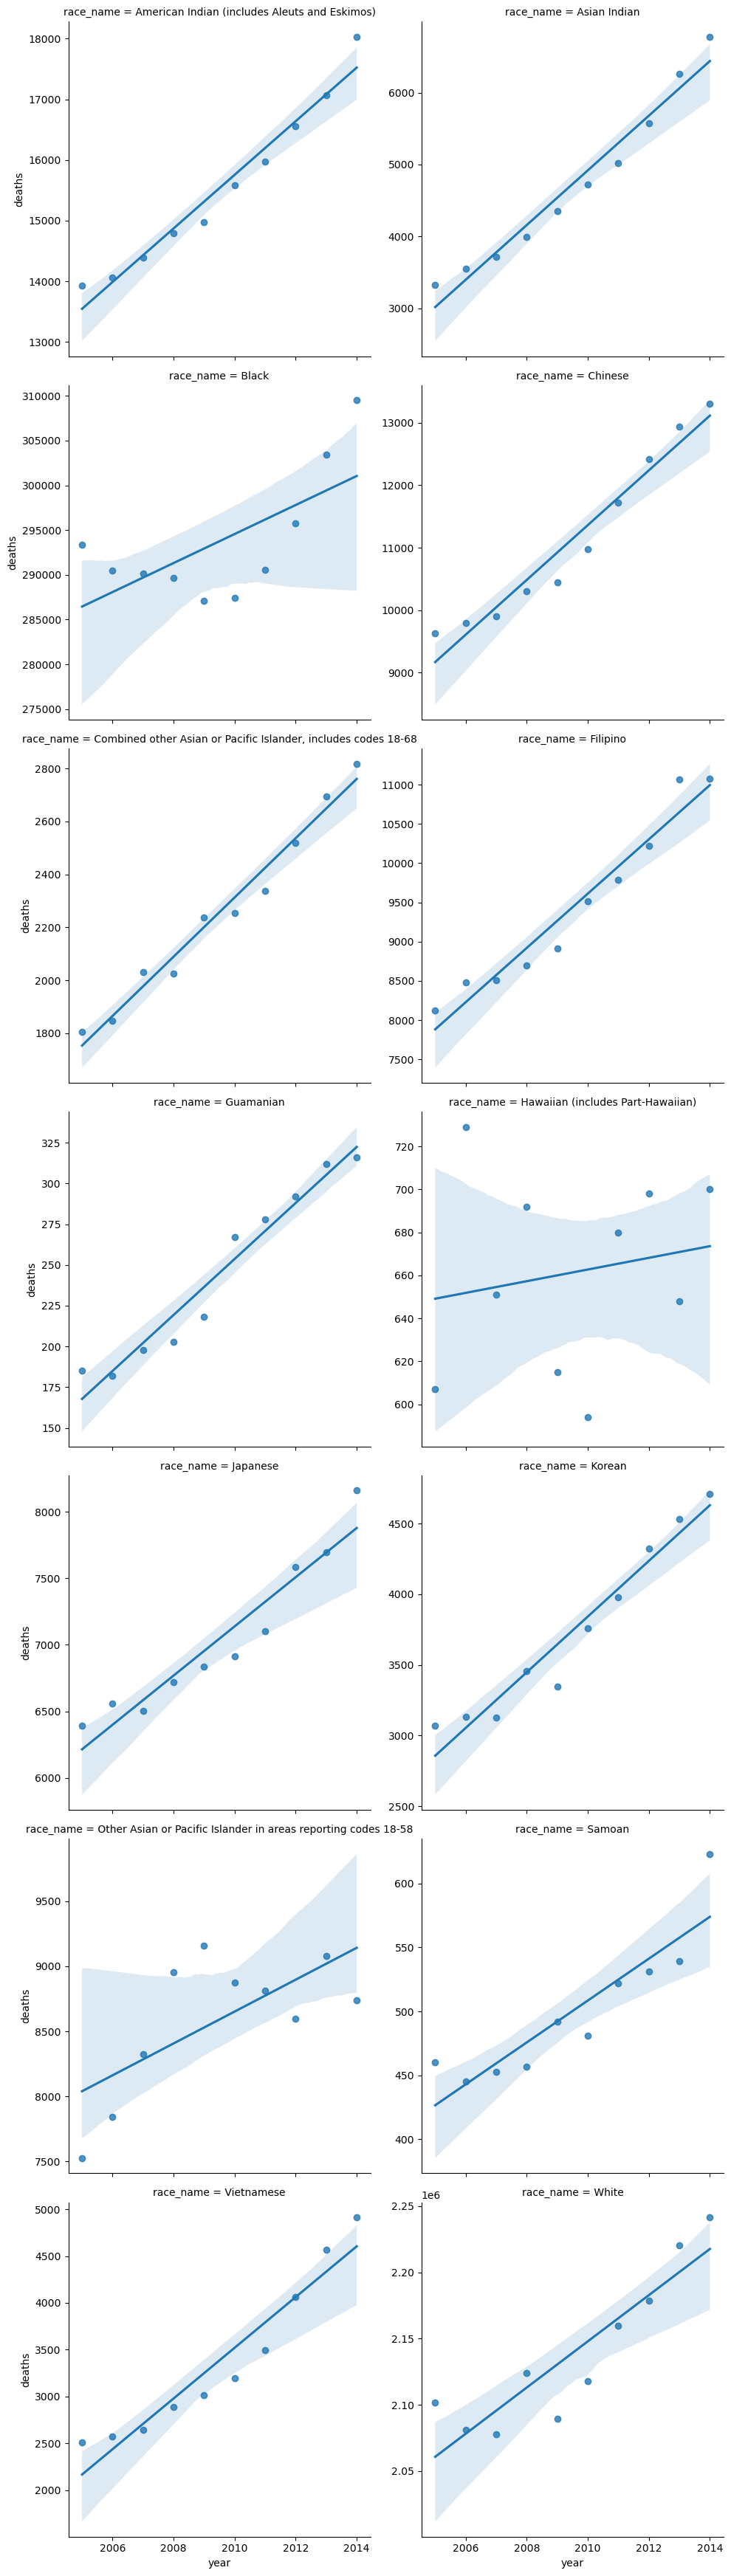

In [8]:
lmplot(data=df.groupby(by=['current_data_year', 'race_name']).size().reset_index().rename(columns={'current_data_year': 'year', 0: 'deaths'}),
       facet_kws=dict(sharey=False), col='race_name', seed=1, col_wrap=2,
       x='year', y='deaths',)

In [9]:
logger.info(msg='done')

__main__ - 2023-06-15 16:48:38,495 - INFO - done
